In [1]:
# Enable this for some more verbose info.
debugging = False
from keras import backend as K
K.clear_session()

/home/saad/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Common imports

In [2]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import random
import collections

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
ROOT_IMAGE_DIR = os.path.abspath("images/")

# Path to the dataset (note this is a shared images directory)
dataset_path = os.path.join(ROOT_IMAGE_DIR, "imgnet_n02114100")

models_dir = os.path.join(ROOT_DIR,  "csci_e89_project/models/")

print("base dataset dir:", dataset_path)
print("base modesl dir:", models_dir)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.model import log

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(models_dir, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


base dataset dir: /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/images/imgnet_n02114100
base modesl dir: /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/models/


In [3]:
# for visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

%matplotlib inline 

In [4]:
############################################################
#  Configurations
############################################################

class DetConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "wolf"

    # A GPU with 12GB memory can fit two images.
    IMAGES_PER_GPU = 2

    CLASS_NAMES = ['wolf']
    
    ALL_CLASS_NAMES = ['BG'] + CLASS_NAMES
                   
    # Number of classes (including background)
    NUM_CLASSES = len(ALL_CLASS_NAMES)

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100    # TODO was 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    TRAINING_VERBOSE = 1

    TRAIN_BN = False
    #  'relu' or 'leakyrelu'
    ACTIVATION = 'relu'

## Directory structure

There are two support directory structures. The first I introduced, the second is based on the  current mrcnn examples.

```
images
|__
   ├── annotations.json
   ├── IMG_xxxx.jpg
   ├── IMG_xxxx.jpg
   ├── ...
   └── IMG_xxxx.jpg
```
 
 
```
images
|__
    <dataset_name>
    ├── train
    │   ├── annotations.json
    │   ├── IMG_0001.jpg
    │   ├── IMG_0002.jpg
    │   ├── ...
    │   └── IMG_nnnn.jpg
    └── val
    │   ├── annotations.json
    │   ├── IMG_xxxx.jpg
    │   ├── IMG_xxxx.jpg
    │   ├── ...
    │   └── IMG_xxxx.jpg
 ```

### VGG Image Annotator 

VGG Image Annotator saves each image in the form:

```
{
    "n02114100_10.JPEG81442": {
        "fileref": "",
        "size": 81442,
        "filename": "n02114100_10.JPEG",
        "base64_img_data": "",
        "file_attributes": {},
        "regions": {
            "0": {
                "shape_attributes": {
                    "name": "polygon",
                    "all_points_x": [ ... ],
                    "all_points_y": [ ... ]
                },
                "region_attributes": {
                    "object_name": "wolf"
                }
            }
        }
    },
    "n02114100_120.JPEG174337": {
        ...
    },
    "n02114100_123.JPEG4410": {
        ...
    },
    ...
```

all_points_x and all_points_y define the polygons for the masks.


In [5]:
# For debugging...

if debugging:
    # Load annotations
    print(dataset_path)
    annotations = json.load(open(os.path.join(dataset_path, "train/annotations.json")))
    annotations = list(annotations.values())  # don't need the dict keys

    # The VIA tool saves images in the JSON even if they don't have any
    # annotations. Skip unannotated images.
    annotations = [a for a in annotations if a['regions']]

    for a in annotations:
        print(a['filename'])


In [6]:
############################################################
#  Dataset
############################################################

# Example usage:
# Load images from a training directory.
#    dataset_train = DetDataset()
#    dataset_train.load_dataset_images(dataset_path, "train", config.CLASS_NAMES)
    
# Alternatively use the convienence function for taking from one directory and spliting into train and test
#   dataset_train, dataset_val = create_datasets(dataset_path+'/train', config.CLASS_NAMES)


class DetDataset(utils.Dataset):

    def load_by_annotations(self, dataset_dir, annotations_list, class_ids):
        """Load a specfic set of annotations and from them images.
        dataset_dir: Root directory of the dataset.
        annotations_list: The annotations (and images) to be loaded.
        class_ids: List of classes to use.
        """
        # Add classes.
        for i, name in enumerate(class_ids):
            # Skip over background if it appears in the class name list 
            index = i + 1
            if name != 'BG':
                print('Adding class {:3}:{}'.format(index, name))
                self.add_class('wolf', index, name)

        # Add images
        for a in annotations_list:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "wolf",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)
                    
        
    def load_dataset_images(self, dataset_dir, subset, class_ids):
        """Load a subset of the dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        class_names: List of classes to use.
        """
        
        # Train or validation dataset?
        assert subset in ["train", "val"]
        
        print(dataset_dir)
        print(subset)
        
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        annotations = json.load(open(os.path.join(dataset_dir, "annotations.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Find the unique classes and track their count
        uniq_class_names = collections.Counter()
        for a in annotations:
            for id, region in a['regions'].items():
                object_name = region['region_attributes']['object_name']    
                uniq_class_names[object_name] += 1

        print(uniq_class_names)

        # Add classes.
        for i, name in enumerate(class_ids):
            # Skip over background if it occurs in the 
            index = i + 1
            if name != 'BG':
                print('Adding class {:3}:{}'.format(index, name))
                self.add_class('wolf', index, name)

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "wolf",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)
            
            
    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        
        # If not an object in our dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] not in self.class_names:
            print("warning: source {} not part of our classes, delegating to parent.".format(image_info["source"]))
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            try:
                rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
                mask[rr, cc, i] = 1
            except:
                print(image_info)
                raise

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "wolf":
            return info["path"]
        else:
            print("warning: DetDataSet: using parent image_reference")
            super(self.__class__, self).image_reference(image_id)


In [7]:
def split_annotations(dataset_dir, train_pct=.8, annotation_filename="annotations.json"):
    """ divide up an annotation file for training and validation
    dataset_dir: location of images and annotation file.
    train_pct: the split between train and val default is .8
    annotation_filename: name of annotation file.
    """
    
    # Load annotations
    annotations = json.load(open(os.path.join(dataset_dir, annotation_filename)))
    annotations = list(annotations.values())  # don't need the dict keys

    # The VIA tool saves images in the JSON even if they don't have any
    # annotations. Skip unannotated images.
    annotations = [a for a in annotations if a['regions']]

    # Find the unique classes and track their count
    uniq_class_names = collections.Counter()
    for a in annotations:
        for id, region in a['regions'].items():
            object_name = region['region_attributes']['object_name']    
            uniq_class_names[object_name] += 1
    
    n_annotations = len(annotations)
    
    # Randomize the annotations then divide
    np.random.shuffle(annotations)
    
    # Divide between training and validation    
    n_for_train = int(n_annotations*train_pct)    
    train_ann = annotations[:n_for_train]
    val_ann = annotations[n_for_train:]
    
    def validate_unique(ann, img_files={}):
        for a in ann:
            filename = a['filename']
            if filename in img_files:
                raise RuntimeError(filename+' already exists')
            else:
                img_files[filename] = 1
        return img_files
                
    img_files = validate_unique(train_ann)            
    img_files = validate_unique(val_ann, img_files)
    assert len(train_ann)+len(val_ann)  == len(img_files)  
    
    return train_ann, val_ann, uniq_class_names
    

In [8]:
def create_datasets(dataset_dir, class_ids, train_pct=.8):
    """ set up the training and validation trainng set.
    dataset_dir: location of images and annotation file.
    class_ids: list of classes that being trained for.
    train_pct: the split between train and val default is .8
    """
    
    train_ann, val_ann, object_counts = split_annotations(dataset_dir, train_pct=train_pct)
    
    train_ds = DetDataset()
    train_ds.load_by_annotations(dataset_dir, train_ann, class_ids)
    
    val_ds = DetDataset()
    val_ds.load_by_annotations(dataset_dir, val_ann, class_ids)
    
    assert len(train_ds.image_info) == len(train_ann) and len(val_ds.image_info) == len(val_ann)
    
    return train_ds, val_ds


## Configuration

In [9]:
# Create an object to hold configuration
config = DetConfig()


## Load dataset

In [10]:
# Load dataset
dataset, _ = create_datasets(dataset_path+"/train",  config.CLASS_NAMES)

# Must call before using the dataset, amount other things,
# this maps the sources to the class ids.
dataset.prepare()

# Print a summary of the dataset and classes
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))


Adding class   1:wolf
Adding class   1:wolf
Image Count: 136
Class Count: 2
  0. BG                                                
  1. wolf                                              


## Display Samples

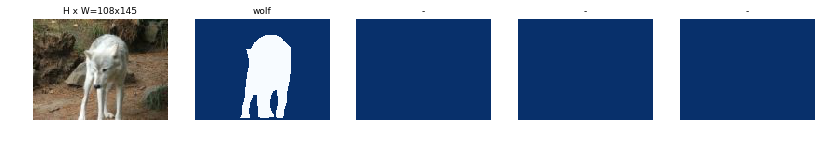

(108, 145, 1)

In [11]:
image_id = 20
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
mask.shape

In [12]:
if debugging:
    for image_id in dataset.image_ids:
        print("image_id: ", image_id)
        image = dataset.load_image(image_id)
        mask, class_ids = dataset.load_mask(image_id)
        visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
        mask.shape

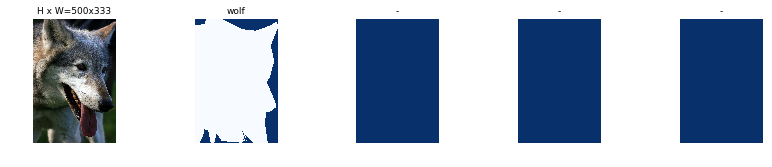

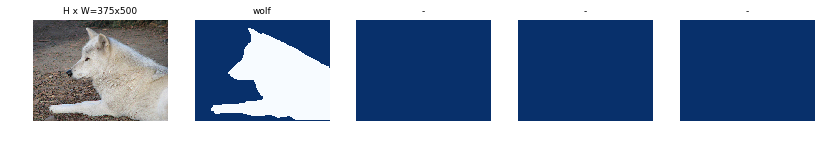

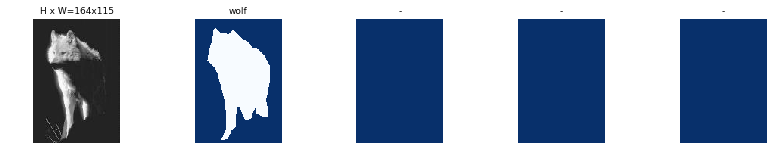

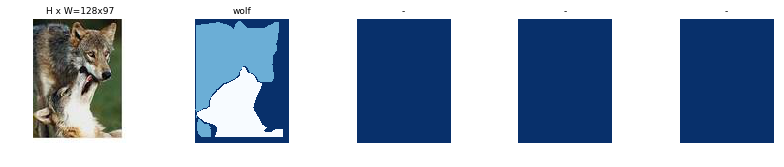

In [13]:
from mrcnn import visualize
from mrcnn.visualize import display_images

# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding boxes

Display sample bounding boxes

image_id  92 /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/images/imgnet_n02114100/train/n02114100_68.JPEG
image                    shape: (200, 250, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (200, 250, 2)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (2, 4)                min:   46.00000  max:  210.00000  int32


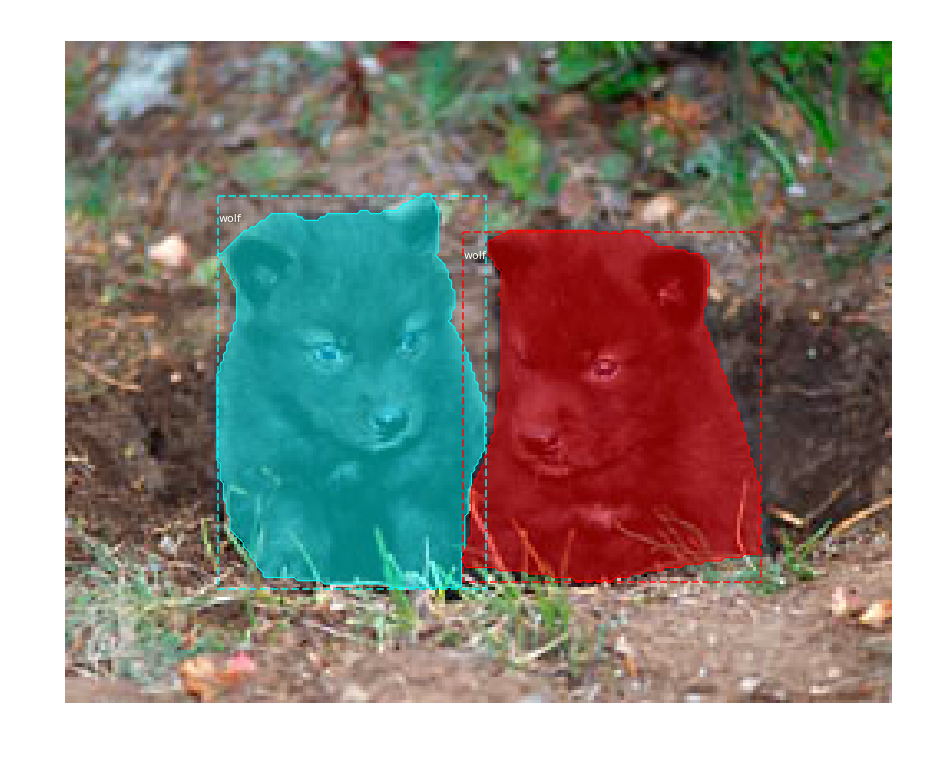

In [14]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)

image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

type(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Prepare images

Images are resized to a common size of 1024x1024. Aspect ration is preserved. If an image is not square, then zero padding is added.

image_id:  20 /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/images/imgnet_n02114100/train/n02114100_174.JPEG
Original shape:  (108, 145, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  248.00000  max:  882.00000  int32


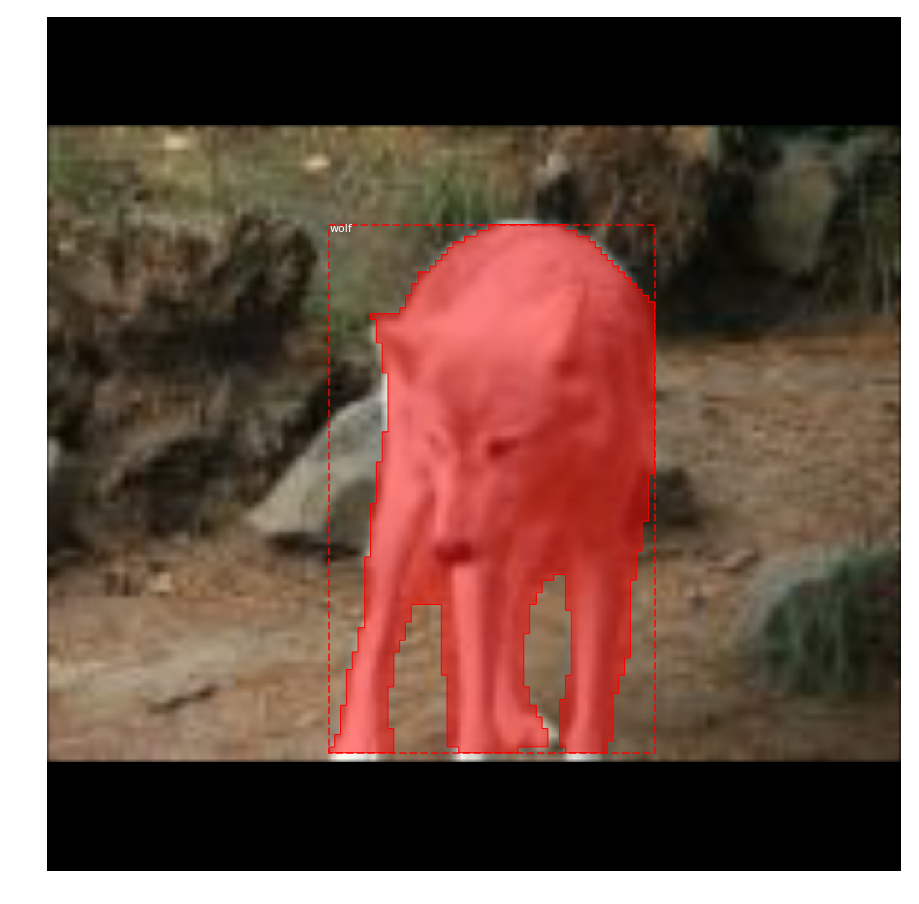

In [15]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks by:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accurate to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  250.00000  uint8
image_meta               shape: (14,)                 min:    1.00000  max: 1024.00000  float64
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  139.00000  max:  911.00000  int32
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


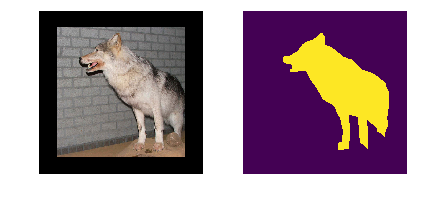

In [16]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

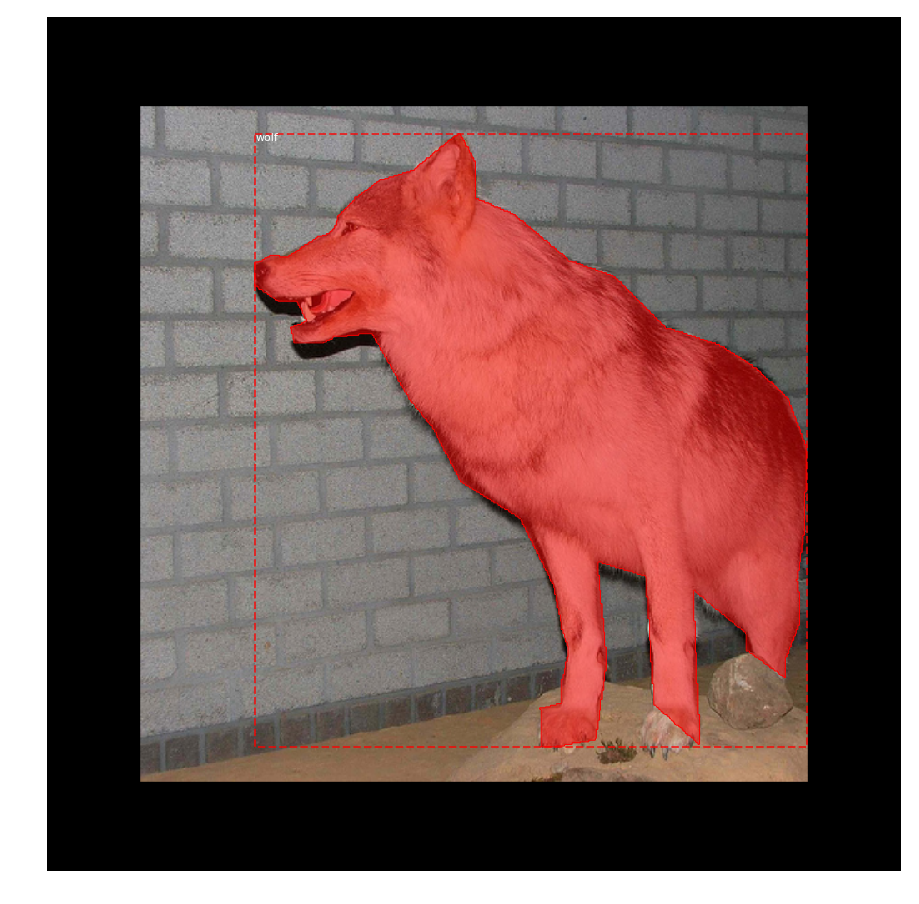

In [17]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Augmentation

In [18]:
# The imgaug library is pretty flexible and make different types of augmentation possible. 
# The deterministic setting is used because any spatial changes to the image must also be 
# done to the mask. There are also some augmentors that are unsafe to apply. From the mrcnn
# library: 
# Augmentors that are safe to apply to masks: 
# ["Sequential", "SomeOf", "OneOf", "Sometimes","Fliplr", 
# "Flipud", "CropAndPad", "Affine", "PiecewiseAffine"]
# Affine, has settings that are unsafe, so always
# test your augmentation on masks

import imgaug as ia
from imgaug import augmenters as iaa

ia.seed(1)

# http://imgaug.readthedocs.io/en/latest/source/augmenters.html#sequential
seq_of_aug = iaa.Sequential([
    iaa.Crop(percent=(0, 0.1)), # random crops
    
    # horizontally flip 50% of the images
    iaa.Fliplr(0.5), 

    # Gaussian blur to 50% of the images
    # with random sigma between 0 and 0.5.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    
    # Apply affine transformations to each image.
    # Scale/zoom them from 90% 5o 110%
    # Translate/move them, rotate them
    # Shear them slightly -2 to 2 degrees.
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-5, 5),
        shear=(-2, 2)
    )
], random_order=True) # apply augmenters in random order


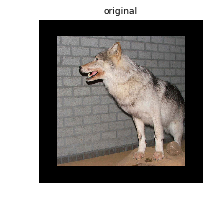

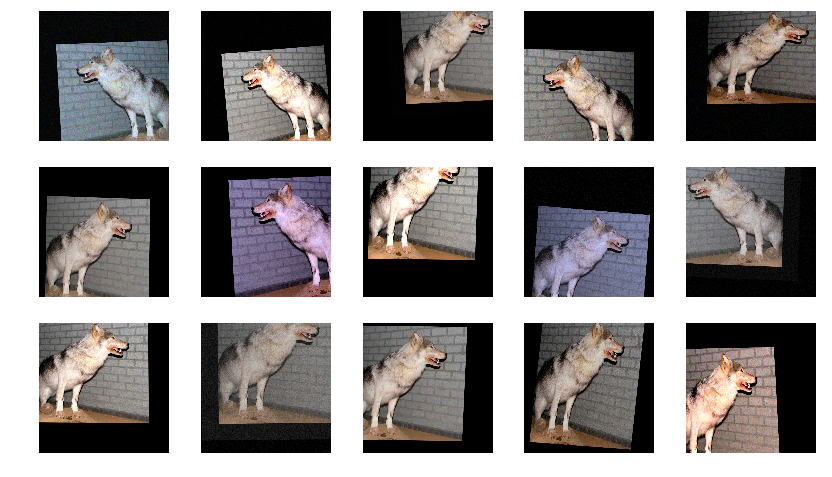

In [19]:
# Some example augmentations using the seq defined above.
display_images( [image], titles=['original'])

image_list = []
for i in range(15):
    image_aug = seq_of_aug.augment_image(image)
    image_list.append( image_aug)
    
display_images( image_list, cols=5)

mask                     shape: (56, 56, 1)           min:    0.00000  max:    1.00000  bool


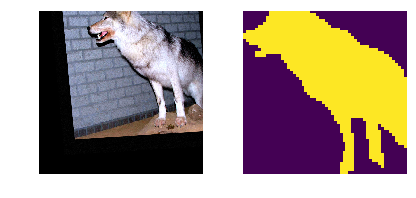

In [20]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augmentation=seq_of_aug, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

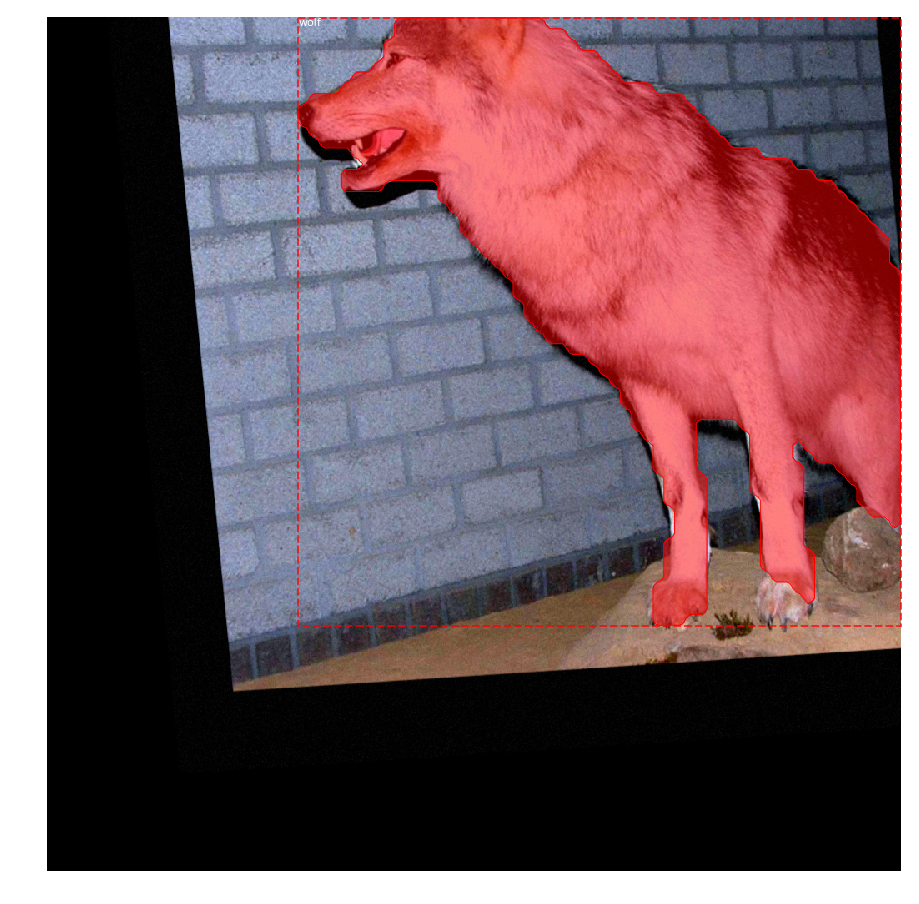

In [21]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchor Boxes

The order of anchor boxes is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:**
In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature meap of the first layer is 256x256, which generates about 200K anchors (256*256*3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example. 

In this implementation we use an anchor stride of 2, which is different from the paper.

In [22]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


Visualize anchors of one cell at the center of the feature map of a specific level.

Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


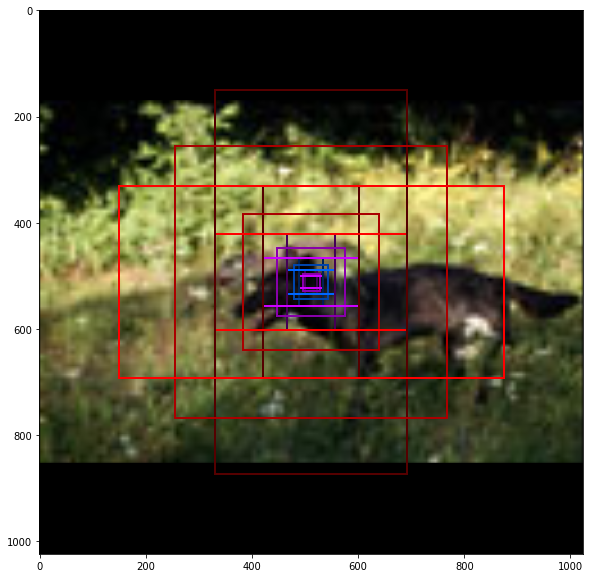

In [23]:
## Visualize anchors of one cell at the center of the feature map of a specific level



# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


# Data Generator

In [24]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True,
    augmentation=seq_of_aug
    )

For debugging...

Run the generator through a set of images to catch any errors. I've seen the following:

* Points in `all_points_x` extending beyond the width
* Points in `all_points_y` extending beyond the height
* `all_points_x` or `all_points_y` somethimes not written correctly.
* If the order changes between the fs and annotation files is not the same there can be an error thrown that looks like the above.



In [25]:
if debugging:
    # Run the generator through a lot of images
    for i in range(10):
        print(i)
        _, _ = next(g)
        

In [26]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 200, 4)           min:    0.00000  max: 1023.00000  int32
mrcnn_class_ids          shape: (4, 200, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 200, 2, 4)        min:   -3.48432  max:    3.71739  float32
mrcnn_mask               shape: (4, 200, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max: 1024.00000  int32
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 261888, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -1.81697  max:    4.35547  float64
image_id:  47 /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/images/imgnet_n02114100/train/n02114100_13335.JPEG


anchors                  shape: (261888, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (1, 4)                min:  294.00000  max:  727.00000  float32
Positive anchors: 1
Negative anchors: 255
Neutral anchors: 261632
BG                     : 160
wolf                   : 40


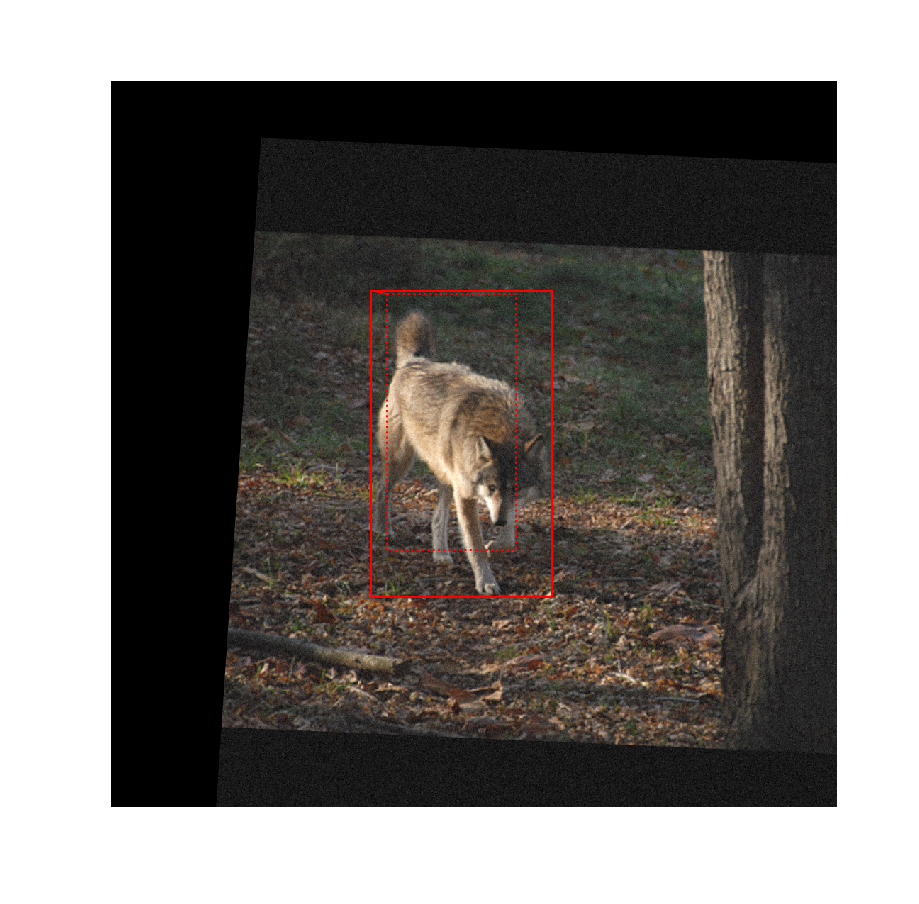

In [27]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

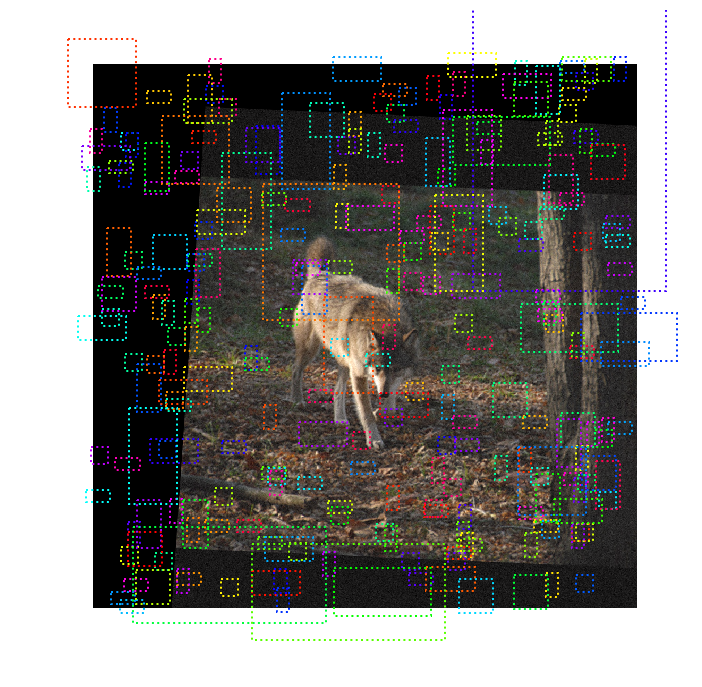

In [28]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

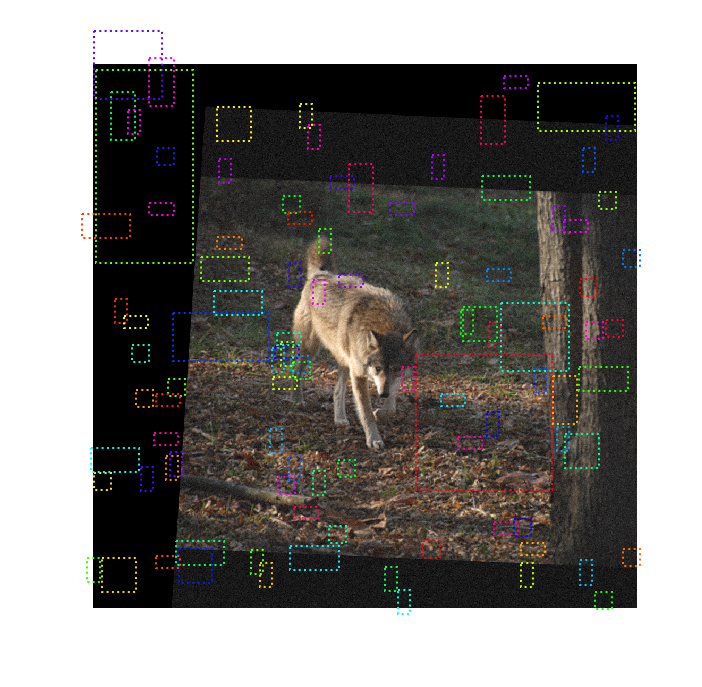

In [29]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## Regions of Interest

Positive ROIs:  40
Negative ROIs:  160
Positive Ratio: 0.20
Unique ROIs: 200 out of 200


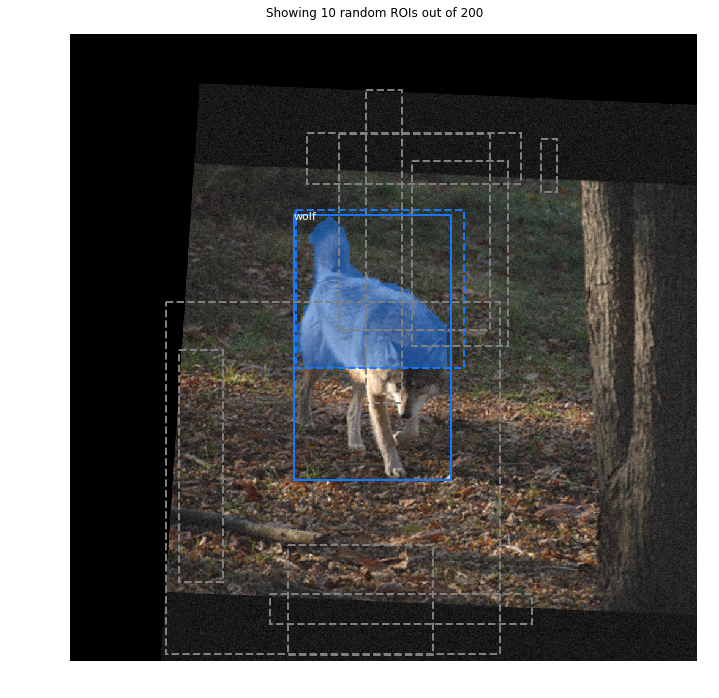

In [30]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

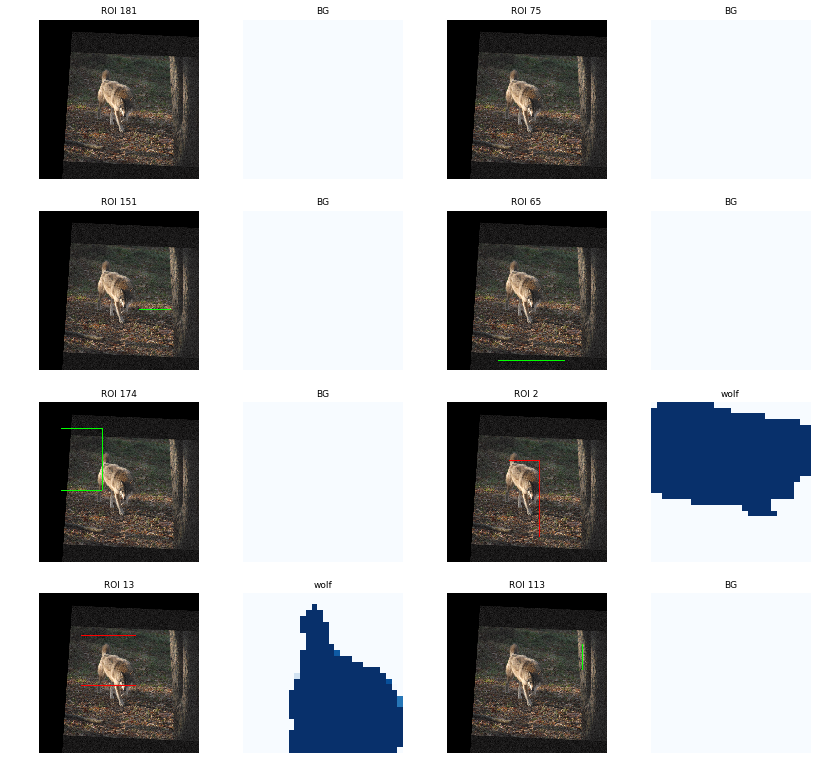

In [31]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [32]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33


# Train

The default implementation uses the ResNet101 and FPN networks. These are very large and they recommend a GPU with 12GB or an Amazon P2 instance.


In [33]:
print("dataset dir:", dataset_path)
print("modesl dir:", models_dir)

dataset dir: /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/images/imgnet_n02114100
modesl dir: /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/models/


In [34]:
# Setup configuration
config = DetConfig()
config.display()


Configurations:
ACTIVATION                     relu
ALL_CLASS_NAMES                ['BG', 'wolf']
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASS_NAMES                    ['wolf']
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MA

In [35]:
# Create the model
model = modellib.MaskRCNN(mode='training', 
                          config=config,
                          model_dir=models_dir)

model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [36]:
# Load the weights

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(models_dir, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
else:
    print("using existing ", COCO_MODEL_PATH)
    
# For the coco dataset exclude the last layers because 
# it requires a matching number of classes
print("loading...", end='')
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

print("loaded.")

using existing  /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/models/mask_rcnn_coco.h5
loading...loaded.


In [37]:
def train(model, dataset_path, epochs=30):
    """Train the model."""
    
    # Create the train and val dataset.
    dataset_train, dataset_val = create_datasets(dataset_path+'/train', config.CLASS_NAMES)

    # Prepare them
    dataset_train.prepare()
    dataset_val.prepare()

    # Experiment with training options.
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    history = model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=epochs,
                layers='heads', 
                augmentation=seq_of_aug
                )
    
    return history

In [38]:
history = train(model, dataset_path, 75)

Adding class   1:wolf
Adding class   1:wolf
Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/models/wolf20180510T2357/mask_rcnn_wolf_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (T

/home/saad/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/75
100/100 [==============================] - 76s 757ms/step - loss: 1.0359 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.2913 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.4136 - mrcnn_mask_loss: 0.3043 - val_loss: 0.6388 - val_rpn_class_loss: 0.0018 - val_rpn_bbox_loss: 0.2387 - val_mrcnn_class_loss: 0.0220 - val_mrcnn_bbox_loss: 0.2066 - val_mrcnn_mask_loss: 0.1697
Epoch 2/75
100/100 [==============================] - 69s 693ms/step - loss: 0.6794 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.2386 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.2075 - mrcnn_mask_loss: 0.2157 - val_loss: 0.5580 - val_rpn_class_loss: 0.0018 - val_rpn_bbox_loss: 0.2110 - val_mrcnn_class_loss: 0.0233 - val_mrcnn_bbox_loss: 0.1477 - val_mrcnn_mask_loss: 0.1742
Epoch 3/75
100/100 [==============================] - 69s 690ms/step - loss: 0.6480 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.2659 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.1618 - mrcnn_mask_loss: 0.2037 - val_loss: 0.5193 - val_rpn_c

Epoch 23/75
100/100 [==============================] - 67s 667ms/step - loss: 0.5072 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.2106 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1674 - val_loss: 0.7056 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0.3941 - val_mrcnn_class_loss: 0.0466 - val_mrcnn_bbox_loss: 0.1003 - val_mrcnn_mask_loss: 0.1629
Epoch 24/75
100/100 [==============================] - 67s 670ms/step - loss: 0.5001 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.2133 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.1673 - val_loss: 0.5668 - val_rpn_class_loss: 0.0014 - val_rpn_bbox_loss: 0.2705 - val_mrcnn_class_loss: 0.0419 - val_mrcnn_bbox_loss: 0.0951 - val_mrcnn_mask_loss: 0.1580
Epoch 25/75
100/100 [==============================] - 67s 670ms/step - loss: 0.4953 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.2233 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.0814 - mrcnn_mask_loss: 0.1552 - val_loss: 0.6104 - val_rp

Epoch 45/75
100/100 [==============================] - 67s 667ms/step - loss: 0.4246 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.1718 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1532 - val_loss: 0.6084 - val_rpn_class_loss: 0.0015 - val_rpn_bbox_loss: 0.3042 - val_mrcnn_class_loss: 0.0426 - val_mrcnn_bbox_loss: 0.0960 - val_mrcnn_mask_loss: 0.1642
Epoch 46/75
100/100 [==============================] - 67s 670ms/step - loss: 0.4429 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.1962 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1533 - val_loss: 0.6272 - val_rpn_class_loss: 0.0017 - val_rpn_bbox_loss: 0.3106 - val_mrcnn_class_loss: 0.0439 - val_mrcnn_bbox_loss: 0.1086 - val_mrcnn_mask_loss: 0.1624
Epoch 47/75
100/100 [==============================] - 67s 667ms/step - loss: 0.4501 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.2005 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1577 - val_loss: 0.6193 - val_rp

Epoch 67/75
100/100 [==============================] - 67s 667ms/step - loss: 0.4281 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.1876 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1472 - val_loss: 0.5992 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0.2517 - val_mrcnn_class_loss: 0.0544 - val_mrcnn_bbox_loss: 0.1083 - val_mrcnn_mask_loss: 0.1831
Epoch 68/75
100/100 [==============================] - 67s 669ms/step - loss: 0.4418 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.2010 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1474 - val_loss: 0.6912 - val_rpn_class_loss: 0.0018 - val_rpn_bbox_loss: 0.3340 - val_mrcnn_class_loss: 0.0366 - val_mrcnn_bbox_loss: 0.1266 - val_mrcnn_mask_loss: 0.1923
Epoch 69/75
100/100 [==============================] - 67s 666ms/step - loss: 0.3749 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.1602 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1332 - val_loss: 0.5867 - val_rp

In [39]:
print(history.history.keys())

dict_keys(['val_loss', 'val_rpn_class_loss', 'val_rpn_bbox_loss', 'val_mrcnn_class_loss', 'val_mrcnn_bbox_loss', 'val_mrcnn_mask_loss', 'loss', 'rpn_class_loss', 'rpn_bbox_loss', 'mrcnn_class_loss', 'mrcnn_bbox_loss', 'mrcnn_mask_loss'])


In [40]:
import math

def plot_history(history):
    
    fig = plt.figure(figsize=(16,10))
       
    n_history_loss = len(history.history)
    n_epochs = len(history.epoch)
    epoch = history.epoch
    
    # The loss is in pairs, one for train, one for val
    loss_stats = [ k for k in history.history.keys() if 'val_' not in k ]
    
    n_cols = 4
    n_rows = math.ceil(len(loss_stats) / n_cols) 
    
    for i, k in enumerate(loss_stats):
        val_k = 'val_'+k
        ax = plt.subplot( n_rows, n_cols, i+1)
        ax.plot(epoch, history.history[k], label=k)
        ax.plot(epoch, history.history[val_k], label=val_k)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.set_title(str(i)+' - '+k)
        plt.legend(shadow=True, fancybox=True)
    
    fig.tight_layout()
    plt.show()
    
    

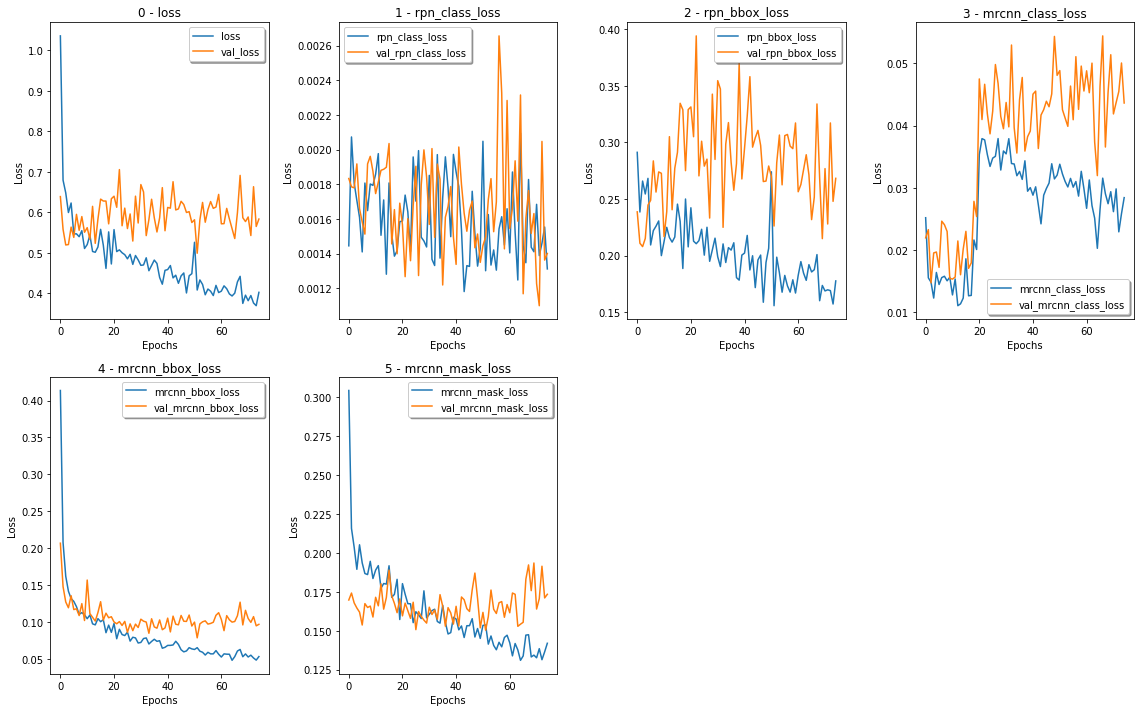

In [41]:
# Plot training stats for each of the networks.
plot_history(history)

# Inference

In [42]:
class InferenceConfig(DetConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 2 # For BG + Others
    
inf_config = InferenceConfig()
inf_model = modellib.MaskRCNN(mode="inference", 
                              config=inf_config,
                              model_dir=models_dir)

inf_config.display()

# Find last trained weights
#weights_path = inf_model.find_last()[1]

# When testing use the latest, for demo use stable model
weights_path = os.path.join(models_dir, "wolf20180508T1124_mask_rcnn_wolf_0075.h5")

print("Using latest weights: ", weights_path)

inf_model.load_weights(weights_path, by_name=True)



Configurations:
ACTIVATION                     relu
ALL_CLASS_NAMES                ['BG', 'wolf']
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASS_NAMES                    ['wolf']
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MA

In [43]:
import glob

def detect_instance(class_names, image_test_dir):
    """
    class_names: list of class names of the dataset
    image_filenames: list of images to analyze
    """

    det_filenames = sorted(glob.glob(image_test_dir+'/*'))

    for f in det_filenames:
        print("Processing image {}".format(f))

        test_img = plt.imread(f)
        print(test_img.shape)

        plt.imshow(test_img)
        # visualize.display_images([test_img])

        # Included in the results from detect are the found:
        # class_ids,their scores and masks.
        results = inf_model.detect([test_img], verbose=1)[0]

        print("Objects detected: ", len(results['class_ids']))

        # Visualize results
        visualize.display_instances(test_img, 
                                    results['rois'], 
                                    results['masks'], 
                                    results['class_ids'], 
                                    class_names, 
                                    results['scores'])

        print(results['class_ids'])

In [44]:

def detect_instances(class_names, image_test_dir):
    """
    class_names: list of class names of the dataset
    image_filenames: list of images to analyze
    """
        
    det_filenames = sorted(glob.glob(image_test_dir+'/*'))

    fig = plt.figure(figsize=(16,10))

    n_cols = 3
    n_rows = math.ceil(len(det_filenames) / n_cols) 
    
    
    for i, f in enumerate(det_filenames):
        
        print("Processing image {}".format(f))
        
        ax = plt.subplot( n_rows, n_cols, i+1)

        test_img = plt.imread(f)

        # Included in the results from detect are the found:
        # class_ids,their scores and masks.
        results = inf_model.detect([test_img], verbose=1)[0]

        print("Objects detected: ", len(results['class_ids']))

        # Visualize results
        visualize.display_instances(test_img, 
                                    results['rois'], 
                                    results['masks'], 
                                    results['class_ids'], 
                                    class_names, 
                                    results['scores'],
                                    ax=ax)

        print(results['class_ids'])
        



Processing image /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/images/test_images/birch_trees.JPEG
Processing 1 images
image                    shape: (581, 964, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Objects detected:  0

*** No instances to display *** 

[]
Processing image /home/saad/notebook/csci_e89/project/saad_mrcnn/csci_e89_project/images/test_images/birch_trees_zoom.JPEG
Processing 1 images
image                    shape: (250, 169, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  

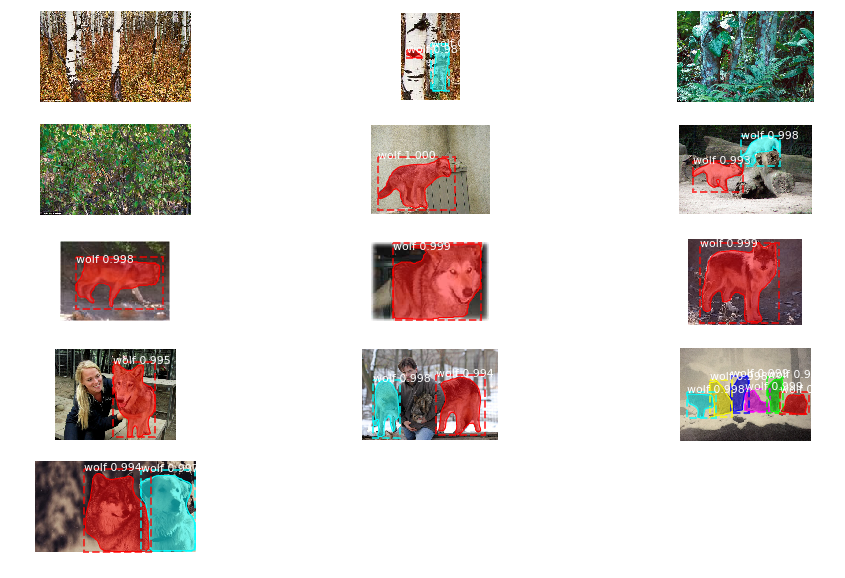

In [45]:
image_test_dir = os.path.join(ROOT_IMAGE_DIR, "test_images/")

if debugging:
    r = detect_instance(inf_config.ALL_CLASS_NAMES, image_test_dir)
else:
    r = detect_instances(inf_config.ALL_CLASS_NAMES, image_test_dir)